## Predict Average Delay Duration for an Airport (Hartsfield–Jackson Atlanta International Airport) 

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pylab import rcParams
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Data Preparation

In [ ]:
df = pd.read_csv('Airline_Delay_Cause.csv')
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)
df

Shape of the data=  (71995, 21)
Column datatypes= 
 year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2025,2,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",78.0,9.0,5.52,0.52,...,0.00,0.12,0.0,0.0,733.0,578.0,16.0,102.0,0.0,37.0
1,2025,2,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",78.0,12.0,5.77,1.62,...,0.00,2.86,0.0,0.0,803.0,379.0,75.0,92.0,0.0,257.0
2,2025,2,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",91.0,13.0,2.47,0.93,...,0.00,5.35,0.0,0.0,964.0,101.0,507.0,197.0,0.0,159.0
3,2025,2,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",56.0,12.0,4.34,0.34,...,0.00,2.00,2.0,1.0,761.0,246.0,35.0,239.0,0.0,241.0
4,2025,2,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2700.0,416.0,83.87,16.73,...,0.16,171.98,24.0,3.0,33668.0,10723.0,1790.0,6851.0,15.0,14289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71990,2022,1,ZW,Air Wisconsin Airlines Corp,STL,"St. Louis, MO: St Louis Lambert International",6.0,1.0,0.29,0.00,...,0.00,0.39,1.0,0.0,85.0,25.0,0.0,27.0,0.0,33.0
71991,2022,1,ZW,Air Wisconsin Airlines Corp,SYR,"Syracuse, NY: Syracuse Hancock International",40.0,7.0,2.02,1.10,...,0.00,2.98,3.0,0.0,746.0,48.0,122.0,52.0,0.0,524.0
71992,2022,1,ZW,Air Wisconsin Airlines Corp,TUL,"Tulsa, OK: Tulsa International",8.0,1.0,0.00,0.00,...,0.00,0.30,1.0,0.0,46.0,0.0,0.0,32.0,0.0,14.0
71993,2022,1,ZW,Air Wisconsin Airlines Corp,TVC,"Traverse City, MI: Cherry Capital",59.0,11.0,2.60,0.00,...,0.00,2.91,3.0,0.0,527.0,138.0,0.0,225.0,0.0,164.0


In [ ]:
# Check data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71995 entries, 0 to 71994
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 71995 non-null  int64  
 1   month                71995 non-null  int64  
 2   carrier              71995 non-null  object 
 3   carrier_name         71995 non-null  object 
 4   airport              71995 non-null  object 
 5   airport_name         71995 non-null  object 
 6   arr_flights          71915 non-null  float64
 7   arr_del15            71885 non-null  float64
 8   carrier_ct           71915 non-null  float64
 9   weather_ct           71915 non-null  float64
 10  nas_ct               71915 non-null  float64
 11  security_ct          71915 non-null  float64
 12  late_aircraft_ct     71915 non-null  float64
 13  arr_cancelled        71915 non-null  float64
 14  arr_diverted         71915 non-null  float64
 15  arr_delay            71915 non-null 

### Data Cleaning

In [ ]:
# Select column that are going to be used for time series analysis
df_cleaned = df[['year', 'month', 'airport', 'arr_delay']]

# Select the airport to be forecast (Hartsfield–Jackson Atlanta International Airport)
df_cleaned = df_cleaned[df_cleaned['airport'] == 'ATL']

df_cleaned.head()

,year,month,airport,arr_delay
4,2025,2,ATL,33668.0
98,2025,2,ATL,7026.0
216,2025,2,ATL,585.0
298,2025,2,ATL,5150.0
415,2025,2,ATL,219491.0


In [ ]:
#Checking null value
df_cleaned.isna().sum()

year         0
month        0
airport      0
arr_delay    0
dtype: int64

In [ ]:
#Check for duplicate row
df_cleaned.duplicated().sum()

0

In [ ]:
#  Group by year and month to get average delay per month
df_cleaned = df_cleaned.groupby(['year', 'month'])['arr_delay'].mean().reset_index()

# Create date column from year + month
df_cleaned['date'] = pd.to_datetime(df_cleaned[['year', 'month']].assign(day=1))

# Set the datetime column as index (for time series models)
df_cleaned = df_cleaned.set_index('date')

# Drop year/month columns after date created because it's no longer needed
df_cleaned = df_cleaned.drop(columns=['year', 'month'])

df_cleaned.head()


,arr_delay
date,
2022-01-01,17532.071429
2022-02-01,13513.785714
2022-03-01,24419.785714
2022-04-01,22433.071429
2022-05-01,23370.714286


Taking the average delay for each month turns your detailed flight data into a format that time series models like SARIMA can use, because the model work best when there's just one number for each time period—like one average delay per month—so they can clearly see patterns and make good predictions.

In [ ]:
result = adfuller(df_cleaned['arr_delay'])
print('p-value:', result[1])


p-value: 0.008596692920672671


The ADF test resulted in a p-value of 0.0086, which is less than 0.05, indicating that the data can be considered stationary and does not require differencing.

### Exploratory Data Analysis

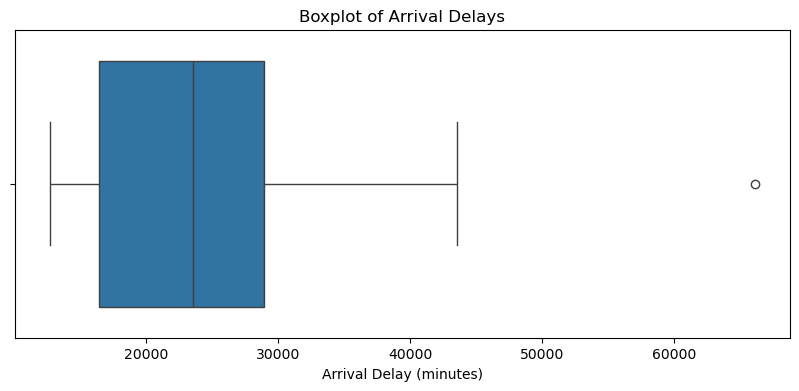

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_cleaned['arr_delay'])
plt.title('Boxplot of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.show()

We chose to analyze the arr_delay (arrival delay in minutes) variable because it is the primary target for our time series forecasting model. Understanding its distribution helps us evaluate the overall delay patterns, detect outliers, and check for skewness or irregularities in the data that might impact model performance, where in the previous boxplot we can see there are outliers, but after the data is cleaned, the updated boxplot shows a more stable distribution. 

This boxplot shows how long arrival delays were, in minutes. Most delays were between 15,000 and 35,000 minutes, with the middle value around 25,000 minutes. The lines (whiskers) show the full range of delays, from about 10,000 to 45,000 minutes. There is also one very big delay (about 65,000 minutes) shown as a dot, which is an outlier. This means it’s much higher than the others and not normal.

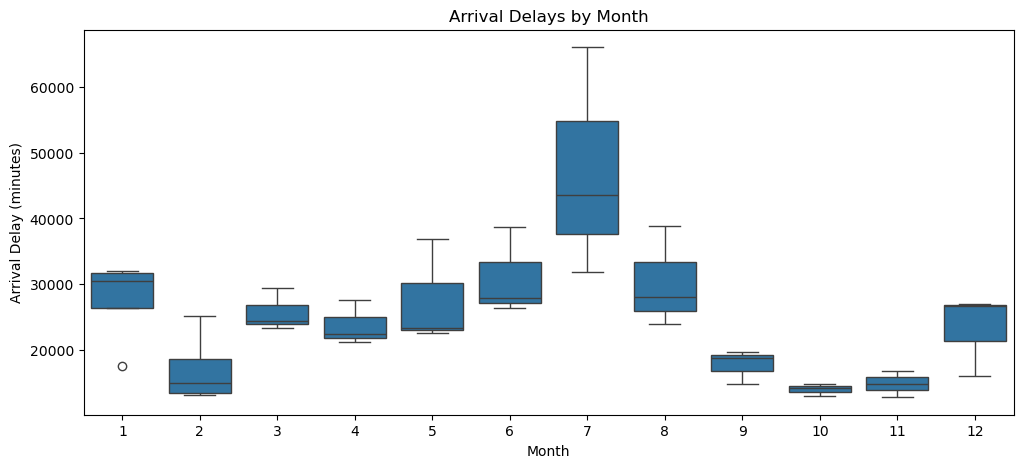

In [ ]:
df_cleaned['month'] = df_cleaned.index.month

plt.figure(figsize=(12, 5))
sns.boxplot(x='month', y='arr_delay', data=df_cleaned)
plt.title('Arrival Delays by Month')
plt.xlabel('Month')
plt.ylabel('Arrival Delay (minutes)')
plt.show()


The data demonstrates noticeable monthly variation in flight arrival delays. July (Month 7) exhibits the highest median delay and the greatest variability, indicating a peak in both the frequency and severity of delays during this summer month. January (Month 1) and December (Month 12) also show relatively high median delays, consistent with known winter travel disruptions.

In contrast, months like February (2), September (9), October (10), and November (11) reflect lower median delays and tighter distributions, suggesting more stable flight operations during these periods. January still contain some extreme outliers, though they are relatively isolated.

Overall, the trend suggests a seasonal influence on delay patterns, with more pronounced disruptions in summer and winter. The presence of broad interquartile ranges and outliers in several months also indicates operational vulnerability to irregular events, which can significantly impact average performance.

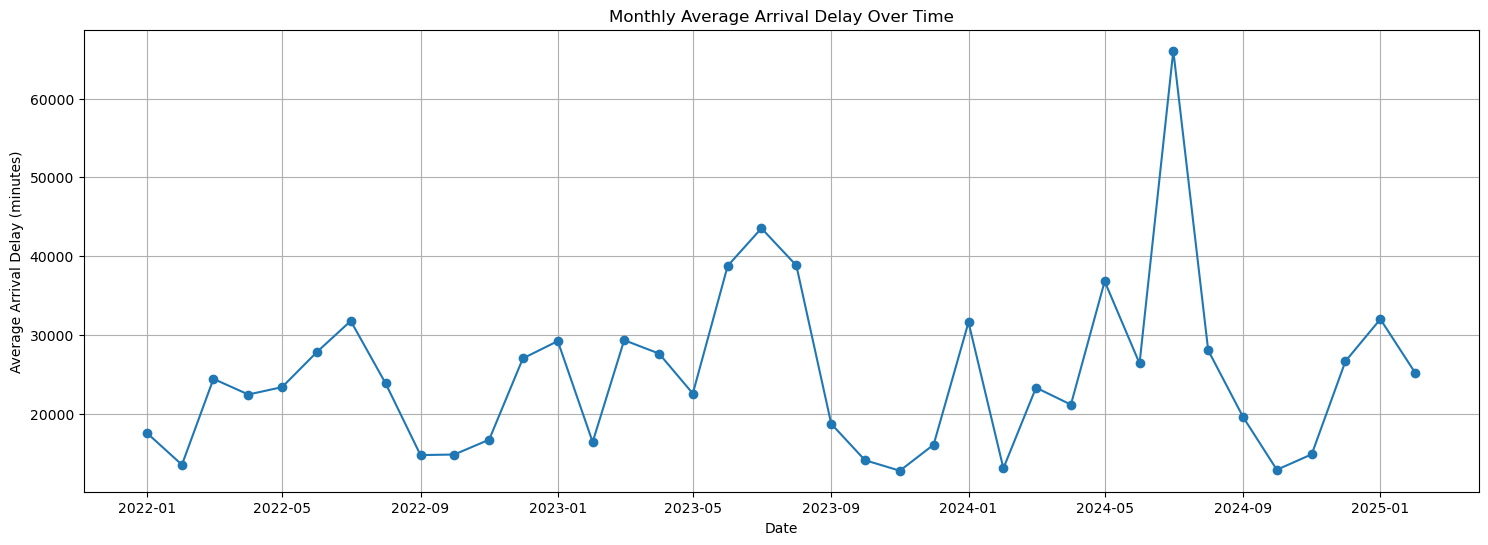

In [ ]:
# See the trend
plt.figure(figsize=(18,6))
plt.plot(df_cleaned.index, df_cleaned['arr_delay'], marker='o')
plt.title('Monthly Average Arrival Delay Over Time')
plt.xlabel('Date')
plt.ylabel('Average Arrival Delay (minutes)')
plt.grid(True)
plt.show()

We analyzed the monthly trend of the arr_delay (arrival delay in minutes) variable to understand the seasonality and temporal patterns in flight delays. This time series trend analysis helps us identify recurring delay behaviors across different months and years, which is essential for accurate forecasting and operational planning.

From the chart (Monthly Average Arrival Delay Over Time), we observe noticeable fluctuations in average delays. Delays tend to rise during mid-year months, particularly with significant spikes in July 2024 and July 2023, suggesting operational strain or disruptions during the peak summer travel season. Periods like September 2022, October 2023, and January 2024 show relatively low average delays, indicating better on-time performance. The dramatic peak in July 2024, where the average delay surpasses 65,000 minutes, stands out as a major anomaly, potentially due to irregular or extreme events.

Overall, the pattern indicates seasonal variability with higher delays mid-year, though outliers in certain months heavily influence the trend.

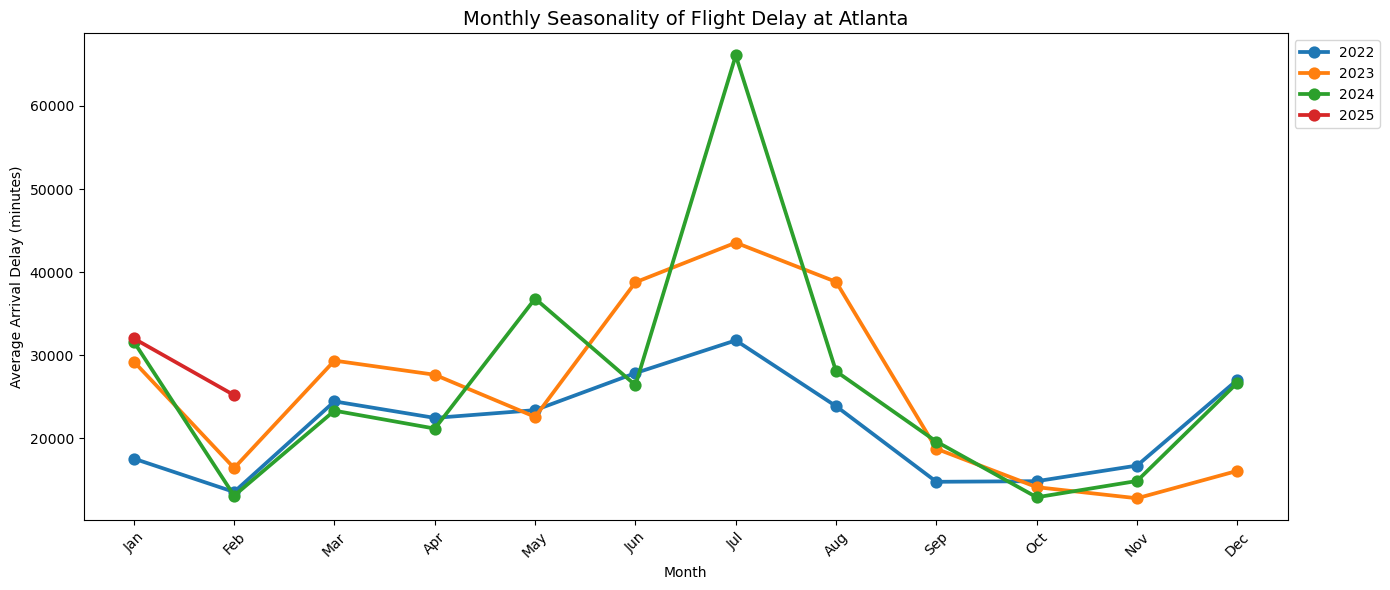

In [ ]:
df_temp = df_cleaned.copy().reset_index()

# Add separate Year and Month columns
df_temp['Year'] = df_temp['date'].dt.year
df_temp['Month'] = df_temp['date'].dt.strftime('%b')  # Short month names (Jan, Feb, ...)

# Create a categorical type for ordered months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_temp['Month'] = pd.Categorical(df_temp['Month'], categories=month_order, ordered=True)

# Plot Seasonality
plt.figure(figsize=(14, 6))
sns.pointplot(data=df_temp, x='Month', y='arr_delay', hue='Year', palette='tab10')
plt.title('Monthly Seasonality of Flight Delay at Atlanta', fontsize=14)
plt.ylabel('Average Arrival Delay (minutes)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

The second chart shows how delay patterns have evolved from 2022 to 2025. Despite year-to-year variation, we can observe recurring seasonal trends—delays tend to increase from spring into summer, peaking notably around July, and then decline sharply in early fall before slightly rising again toward the end of the year. The most significant spike appears in July 2024, where average arrival delays soar above 66,000 minutes, suggesting an unusual disruption or extreme event that year. The consistency of peak delays during mid-year and troughs in the fall confirms a strong seasonal component in Atlanta’s flight delay patterns.

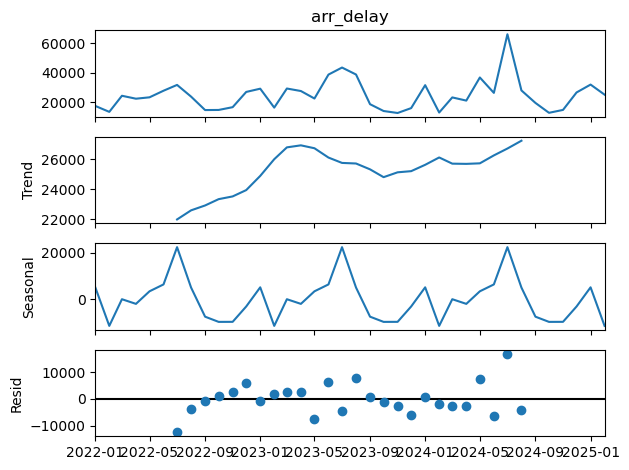

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df_cleaned['arr_delay'], model='additive')
fig = decomposition.plot()
plt.show()

Based on the time series decomposition of arrival delays, it is evident that the data exhibits strong seasonality and a moderately stable trend, making it well-suited for time series forecasting. For short-term forecasts (1 month), a Simple Exponential Smoothing (SES) model would be appropriate due to its responsiveness to recent changes and minimal assumption of trend or seasonality. However, for medium-term forecasting (up to 6 months), more robust models like SARIMA are recommended.

### Train-Test Split

In [ ]:
ts = df_cleaned['arr_delay'].sort_index()

# Predicting next month
train_1m = ts[:'2025-01'] # Up to and including January 2025
test_1m = ts['2025-02'] # Only February 2025

# Predicting next 6 months
train_6m = ts[:'2024-08'] # Up to and including August 2024
test_6m = ts['2024-09':'2025-02'] # September 2024 to February 2025


### Creating Model

#### SES (Simple Exponential Smoothing)

In [ ]:
ses_model_1m = SimpleExpSmoothing(train_1m, initialization_method="estimated").fit()

c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\celin\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


#### SARIMA

In [ ]:
sarima_model = pm.auto_arima(train_6m, seasonal=True, m=12, error_action='ignore')

### Do Forecasting

In [ ]:
# SES forecast
ses_forecast_1m = ses_model_1m.forecast(len(test_1m))

# SARIMA forecast
sarima_forecast = sarima_model.predict(len(test_6m)) 

In [ ]:
ses_forecast_1m

2025-02-01    24955.245093
Freq: MS, dtype: float64

In [ ]:
sarima_forecast

2024-09-01    18713.428571
2024-10-01    14091.866667
2024-11-01    12756.214286
2024-12-01    16057.357143
2025-01-01    31606.071429
2025-02-01    13064.285714
Freq: MS, dtype: float64

### Model Evaluation

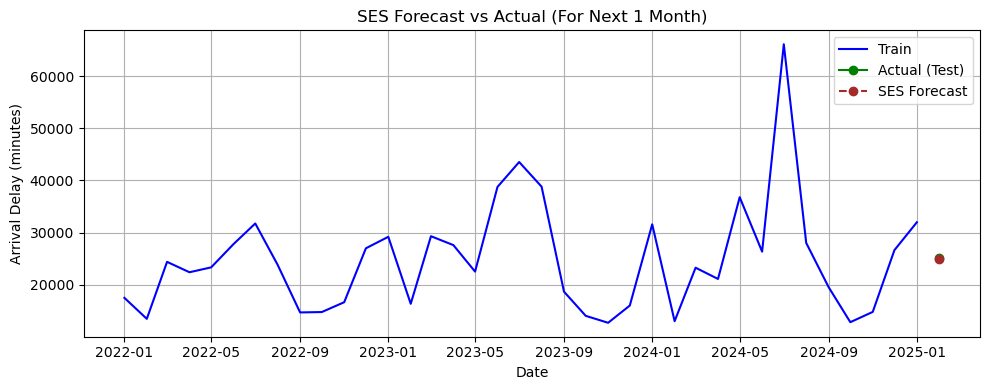

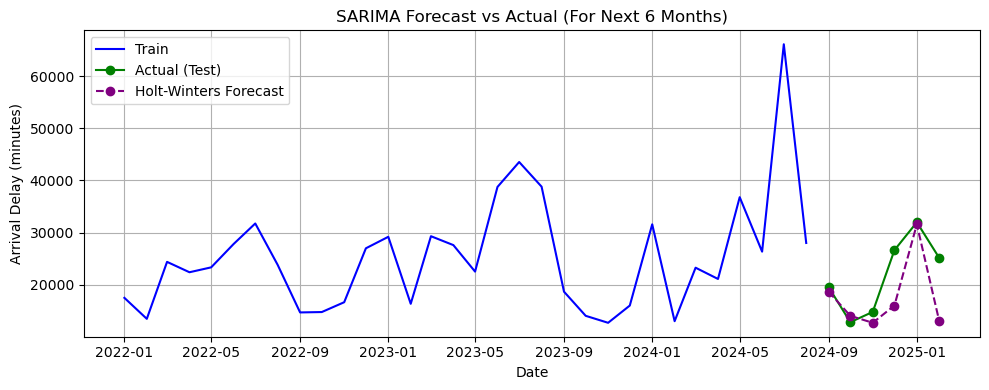

In [ ]:
# Ensure forecasts are pandas Series with correct index
sarima_forecast = pd.Series(sarima_forecast, index=test_6m.index)

# Plot SES vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_1m.index, train_1m, label='Train', color='blue')
plt.plot(test_1m.index, test_1m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_1m.index, ses_forecast_1m, label='SES Forecast', color='brown', linestyle='--', marker='o')
plt.title('SES Forecast vs Actual (For Next 1 Month)')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot SARIMA vs Test
plt.figure(figsize=(10, 4))
plt.plot(train_6m.index, train_6m, label='Train', color='blue')
plt.plot(test_6m.index, test_6m, label='Actual (Test)', color='green', marker='o')
plt.plot(test_6m.index, sarima_forecast, label='Holt-Winters Forecast', color='purple', linestyle='--', marker='o')
plt.title('SARIMA Forecast vs Actual (For Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Make sure forecasts and test are aligned
ses_1m = pd.Series(ses_forecast_1m, index=test_1m.index)
sarima_forecast = pd.Series(sarima_forecast, index=test_6m.index)

# MSE
mse_ses_1m = mean_squared_error(test_1m, ses_1m)
mse_sarima = mean_squared_error(test_6m, sarima_forecast)

# MAPE
mape_ses_1m = mean_absolute_percentage_error(test_1m, ses_1m)
mape_sarima = mean_absolute_percentage_error(test_6m, sarima_forecast)

# Print Results
print("=== Mean Squared Error (MSE) ===")
print("SES (Prediction Next 1 Month):", mse_ses_1m)
print("SARIMA (Prediction Next 6 Months):", mse_sarima)

print("\n=== Mean Absolute Percentage Error (MAPE) ===")
print("SES (Prediction Next 1 Month):", mape_ses_1m)
print("SARIMA (Prediction Next 6 Months):", mape_sarima)


=== Mean Squared Error (MSE) ===
SES (Prediction Next 1 Month): 47044.64003194198
SARIMA (Prediction Next 6 Months): 44303781.25693501

=== Mean Absolute Percentage Error (MAPE) ===
SES (Prediction Next 1 Month): 0.008616579257458006
SARIMA (Prediction Next 6 Months): 0.19501734999398676


The SES (Simple Exponential Smoothing) model was evaluated using two commonly used error metrics in time series forecasting: Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE), to assess the accuracy of its predictions. For the 1-month forecast, the SES model achieved a low MSE of 47,044.64, indicating that the average squared difference between predicted and actual values is minimal. In contrast, the MSE increased significantly for the 6-month SARIMA forecast, reaching 44,303,781.36 , reflecting greater prediction errors over longer horizons.

Similarly, the MAPE results show that the 1-month SES forecast performs exceptionally well with an error of only 0.86%, demonstrating highly accurate predictions. However, the MAPE rises 19.50% for the 6-month SARIMA forecast, indicating reduced reliability as the forecast period extends. These results suggest that while the SES model is highly effective for short-term forecasting, its accuracy diminishes over longer periods, where more complex models like SARIMA become more appropriate depending on the seasonal characteristics of the data.